# 0D Reactor: Postprocessing the FNN for the Decoder

In [1]:
### Importing Libraries

import sys
print(sys.version)
import os
import time


### Defining WORKSPACE_PATH

# WORKSPACE_PATH = os.environ['WORKSPACE_PATH']
WORKSPACE_PATH = os.path.join(os.getcwd(), '../../../../../../')
ROMNet_fld     = os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/')

### Importing External Libraries

import numpy                             as np
import pandas                            as pd


### Importing Matplotlib and Its Style

import matplotlib.pyplot                 as plt

#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/presentation.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/zoomed.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_1column.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_2columns.mplstyle'))


# from scipy.integrate import solve_ivp
# import pyDOE
# from PCAfold         import PCA          as PCAA


import romnet                            as rmnt

3.9.12 (main, Mar 26 2022, 15:51:13) 
[Clang 12.0.0 (clang-1200.0.32.29)]


Missing colon in file PosixPath('/Users/sventur/.matplotlib/stylelib/paper_2columns.mplstyle'), line 1 ('f#### MATPLOTLIBRC FORMAT')


## Defining Input Data

In [2]:
NVarsRed        = 10
n_ics           = 1000

path_to_run_fld = os.path.join(WORKSPACE_PATH, 'ROMNet/0DReact_Isobaric_1000Cases_CH4_Decoder/FNN/Run_1/')
FigDir          = None #os.path.join(WORKSPACE_PATH, '../Desktop/Paper_Figures_DeepONet_TEMP/')

LineVec         = ['-',':','--','.-']*10
ColorVec        = ['#190707', '#dd3232', '#0065a9', '#348a00','#985396','#f68b69']

## Loading ROMNet's Input Data File

In [3]:
print("\n[ROMNet]: Reading Input File from: ", path_to_run_fld)
sys.path.insert(0, path_to_run_fld)

print("\n[ROMNet]: Keep Loading Modules and Functions...")
from ROMNet_Input import inputdata

print("\n[ROMNet]: Initializing Input ...")
InputData               = inputdata(WORKSPACE_PATH)


InputData.InputFilePath = path_to_run_fld+'/ROMNet_Input.py'
InputData.train_int_flg = 0
InputData.path_to_run_fld  = path_to_run_fld


[ROMNet]: Reading Input File from:  /Users/sventur/WORKSPACE/ROMNet/romnet/scripts/postprocessing/0DReactor/Decoder/../../../../../../ROMNet/0DReact_Isobaric_500Cases_CH4_Decoder_/FNN/Run_1/

[ROMNet]: Keep Loading Modules and Functions...

[ROMNet]: Initializing Input ...


## Loading Tensorflow's Model for the Network 

In [4]:
surrogate_type = InputData.surrogate_type
if (surrogate_type == 'FNN-SourceTerms'):
    surrogate_type = 'FNN'

Net   = getattr(rmnt.nn, surrogate_type)

model = rmnt.model.Model_TF(InputData)

if (InputData.phys_system is not None):
    System = getattr(rmnt.pinn.system, InputData.phys_system)
    system = System(InputData)
    
model.build(InputData, None, Net, system)#, loadfile_no='000027')

NN    = model.net


[ROMNet - model_tf.py    ]:   Initializing the ML Model

[ROMNet - model_tf.py    ]:   Building the ML Model

[ROMNet - fnn.py                    ]:   Constructing Feed-Forward Network: 
[ROMNet - system_of_components.py   ]:     Constructing System of Components: FNN
[ROMNet - component.py              ]:       Constructing Component: FNN
[ROMNet - sub_component.py          ]:         Constructed Sub-Component: Main with Layers:       ListWrapper([<romnet.nn.building_blocks.normalization.CustomNormalization object at 0x16475b7c0>, <keras.layers.core.dense.Dense object at 0x164ba2370>, <keras.layers.core.dense.Dense object at 0x164c1a460>, <keras.layers.core.dense.Dense object at 0x164c1af10>, <keras.layers.core.dense.Dense object at 0x164ba2850>, <keras.layers.core.dense.Dense object at 0x164bdd910>])

[ROMNet - model_tf.py    ]:   Loading ML Model Parameters from File:  /Users/sventur/WORKSPACE/ROMNet/romnet/scripts/postprocessing/0DReactor/Decoder/../../../../../../ROMNet/0DReact_I

In [5]:
FileName = InputData.path_to_data_fld+'/../../../'+str(NVarsRed)+'PC/ROM/A.csv'
A        = pd.read_csv(FileName, delimiter=',', header=None).to_numpy()
AT       = A.T

FileName = InputData.path_to_data_fld+'/../../../'+str(NVarsRed)+'PC/ROM/C.csv'
C        = pd.read_csv(FileName, delimiter=',', header=None).to_numpy()

FileName = InputData.path_to_data_fld+'/../../../'+str(NVarsRed)+'PC/ROM/D.csv'
D        = pd.read_csv(FileName, delimiter=',', header=None).to_numpy()

FileName    = InputData.path_to_data_fld+'/../../../'+str(NVarsRed)+'PC/ROM/ToOrig_Mask.csv'
ToOrig_Mask = pd.read_csv(FileName, delimiter=',', header=None).to_numpy(int)[:,0]

## Evaluating Branch on Test Data

In [6]:
Vars       = []
for iVars in range(1,NVarsRed+1):
    Vars.append('PC_'+str(iVars))
input_vars = Vars

output_vars    = InputData.output_vars

In [7]:
FileName     = InputData.path_to_data_fld+'/valid/pts/Input.csv'
input_data   = pd.read_csv(FileName)[input_vars]

FileName     = InputData.path_to_data_fld+'/valid/pts/Output.csv'
output_data  = pd.read_csv(FileName)[output_vars]

In [8]:
yMat         = model.predict(input_data)    

#yMat_PCA     = input_data.to_numpy().dot(A) * D[:,0] + C[:,0]

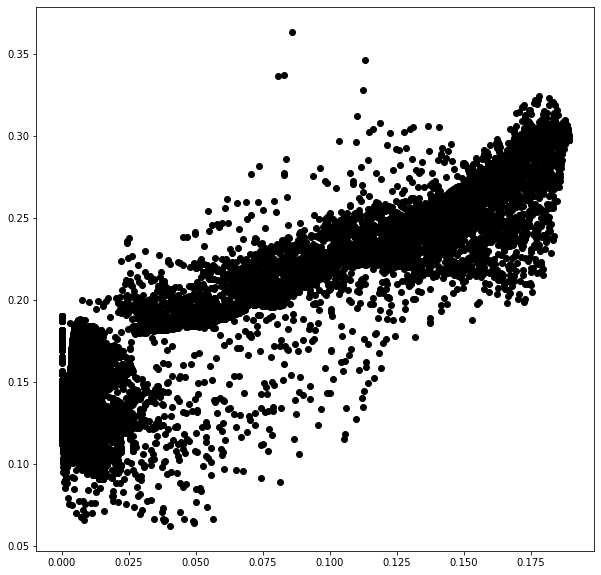

In [9]:
SoI          = 'CH4'
iS           = list(output_vars).index(SoI)

plt.figure(figsize=(10,10))
plt.plot(output_data[SoI], yMat[:,iS], 'ko')
#plt.plot(output_data[SoI], yMat_PCA[:,iS+1], 'ro')
#plt.plot(10**(output_data[SoI]-20), 10**(yMat[:,iS]-20), 'ko')



#plt.plot([yMat[:,iS].min()-0.1, yMat[:,iS].max()*1.5],[yMat[:,iS].min()-0.1, yMat[:,iS].max()*1.5], 'k-')

## Plotting Loss Histories

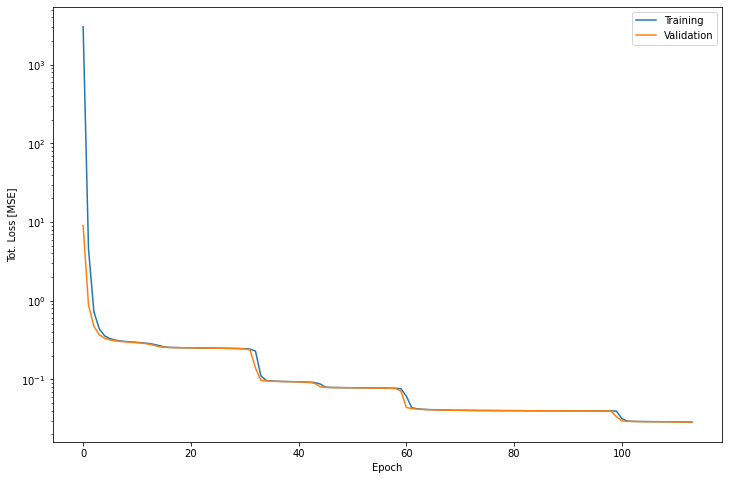

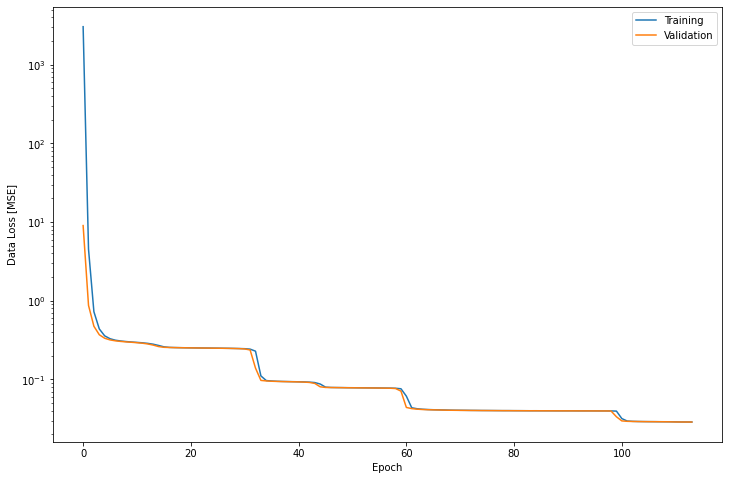

In [10]:
Data    = pd.read_csv(path_to_run_fld+'/Training/History.csv')

# OldRun  = 'Run_39'
# DataOld = pd.read_csv(path_to_run_fld+'/../'+OldRun+'/Training/History.csv')

fig  = plt.figure(figsize=(12,8))
plt.plot(Data['tot_loss'],      label='Training')
plt.plot(Data['val_tot_loss'],  label='Validation')
# plt.plot(DataOld['tot_loss'],     label='Training, '+OldRun)
# plt.plot(DataOld['val_tot_loss'], label='Validation, '+OldRun)
plt.xlabel('Epoch')
plt.ylabel('Tot. Loss [MSE]')
plt.legend()
plt.yscale('log')

fig  = plt.figure(figsize=(12,8))
plt.plot(Data['pts_loss'],      label='Training')
plt.plot(Data['val_pts_loss'],  label='Validation')
# plt.plot(DataOld['pts_loss'],     label='Training, '+OldRun)
# plt.plot(DataOld['val_pts_loss'], label='Validation, '+OldRun)
plt.xlabel('Epoch')
plt.ylabel('Data Loss [MSE]')
plt.legend()
plt.yscale('log')
#plt.ylim([1.e-2, 1.e0])

# fig  = plt.figure(figsize=(12,8))
# plt.plot(Data['scs_loss'],     label='Training')
# plt.plot(Data['val_scs_loss'], label='Validation')
# plt.xlabel('Epoch')
# plt.ylabel('S.C.s Loss [MSE]')
# plt.legend()
# plt.yscale('log')

# fig  = plt.figure(figsize=(12,8))
# plt.plot(Data['ics_loss'],     label='Training')
# plt.plot(Data['val_ics_loss'], label='Validation')
# plt.xlabel('Epoch')
# plt.ylabel('I.C.s Loss [MSE]')
# plt.legend()
# plt.yscale('log')

In [11]:
output_vars

array(['H2', 'H', 'O', 'O2', 'H2O', 'HO2', 'H2O2', 'C', 'CH', 'CH2',
       'CH2(S)', 'CH3', 'CH4', 'CO', 'CO2', 'HCO', 'CH2O', 'CH2OH',
       'CH3O', 'CH3OH', 'C2H', 'C2H2', 'C2H3', 'C2H4', 'C2H5', 'C2H6',
       'HCCO', 'CH2CO', 'HCCOH', 'N', 'NH', 'NH2', 'NH3', 'NNH', 'N2O',
       'HNO', 'CN', 'HCN', 'H2CN', 'HCNN', 'HCNO', 'HOCN', 'HNCO', 'NCO',
       'C3H7', 'C3H8', 'CH2CHO', 'CH3CHO'], dtype=object)

In [14]:
i_ics       = 2

FileName    = InputData.path_to_data_fld+'/../../../10PC/test/ext/PC.csv.'+str(i_ics)
xPred       = pd.read_csv(FileName, delimiter=',')

FileName    = InputData.path_to_data_fld+'/../../../Orig/test/ext/y.csv.'+str(i_ics)
yPred       = pd.read_csv(FileName, delimiter=',')

In [15]:
yMat         = model.predict(xPred[input_vars])    

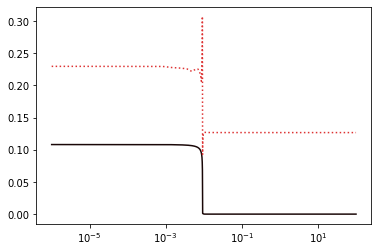

In [17]:
SoI          = 'CH4'
iS           = list(output_vars).index(SoI)

plt.plot(yPred['t'], yPred[SoI],      color=ColorVec[0])
plt.plot(xPred['t'], yMat[:,iS], ':', color=ColorVec[1])
#plt.plot(xPred['t'], 10**(yMat[:,iS]-20), ':', color=ColorVec[1])
plt.xscale('log')

In [ ]:
output_vars